In [7]:
from qutip import *
import numpy as np
from itertools import combinations
from scipy.special import jn_zeros

# helper: operator at one site
def spin_only_op(op, site, N):
    ops = [qeye(2) for _ in range(N)]
    ops[site] = op
    return tensor(*ops)

def g_t(t, args):
    g0 = args['g0']
    w = args['omega']
    return g0 * np.cos(w * t)

def gdot_t(t, args):
    g0 = args['g0']
    w = args['omega']
    return g0 * w * np.cos(w * t)

def coeff(t, args):
    return (g_t(t, args) - gdot_t(t, args)) / np.sqrt(N)


def j_ij(Jvalue, i,j, beta):
    return Jvalue/(np.abs(i-j))**beta

def h0_ham(N, beta, Jvalue, n_ph, hbar, omega):
    sx,sy,sz = sigmax(), sigmay(), sigmaz()
    empt = qzero(2**N) + 1j * qzero(2**N)
    H0, H1, H2 = empt, empt, empt

    comb = combinations(np.arange(N), 2)
    for nm in list(comb):
        i,j= np.array(nm)
        id = qeye(2**i)
        dim11 = j-i-1
        id1 = qeye(2**dim11)
        dim12 = N-1-j
        id2 = qeye(2**dim12)
        H0 = H0 + Qobj(tensor(id, tensor(sz, tensor(id1, tensor(sz,id2)))).full()) * j_ij(Jvalue, i,j, beta)
        
    for i in range(N):
        id = qeye(2 ** i)    
        dim11 = N-1-i
        id1 = qeye(2 ** dim11)
        H1 = H1 + Qobj(tensor(id,tensor(sx,id1)).full())
        
    for i in range(N):
        id = qeye(2 ** i)    
        dim11 = N-1-i
        id1 = qeye(2 ** dim11)
        H2 = H2 + Qobj(tensor(id,tensor(sz,id1)).full())
        
    # photon operators
    a = destroy(n_ph)
    adag = a.dag()
    I_ph = qeye(n_ph)
    
    H0 = Qobj(tensor(H0, qeye(n_ph)).full())
    H1 = Qobj(tensor(H1, a + adag).full())/np.sqrt(N)
    H2 = Qobj(tensor(H2, I_ph).full())

    return H0 * 2/N, H1, H2

def floquet_quasienergies(H_td, omega, g0):
    T = 2*np.pi/omega
    args = {'g0': g0, 'omega': omega}
    modes, eps = floquet_modes(H_td, T, args = args)
    eps_fold = ((np.array(eps) + 0.5*omega) % omega) - 0.5*omega
    return np.sort(np.real_if_close(eps_fold))

print("Function defined !")


Function defined !


In [8]:
N = 5
n_ph = 10
hbar = 1.0
beta = float('inf')
Jvalue = 1.0
omega = 20.0

# Freezing point
# Freezing point (first zero of J0)
frz = jn_zeros(0, 1)[0]
g0_freeze = (omega/4) * frz

# Off-freezing reference point
g0_off = 0.5 * g0_freeze

# Hamilton is defined
H0, H1, H2 = h0_ham(N, beta, Jvalue, n_ph, hbar, omega)
H0 = Qobj(H0.full())
H1 = Qobj(H1.full())
H2 = Qobj(H2.full())

H_td = [H0, [H1, g_t]]

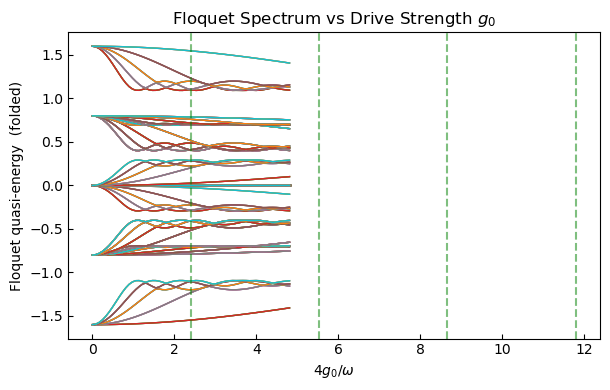

In [9]:
import matplotlib.pyplot as plt

def floquet_spectrum_vs_g0(H_td, omega, g0_values):
    spectrum = []
    for g0 in g0_values:
        eps = floquet_quasienergies(H_td, omega, g0)
        spectrum.append(eps)
    return np.array(spectrum)

# Sweep g0 values
g0_values = np.linspace(0, 2*g0_freeze, 60)   # up to 2× first freezing point
spectrum = floquet_spectrum_vs_g0(H_td, omega, g0_values)

# Convert to scaled variable (this is what appears in freezing theory: 4g0/omega)
xvals = 4 * g0_values / omega

plt.figure(figsize=(6.2,4))
for n in range(spectrum.shape[1]):
    plt.plot(xvals, spectrum[:, n], lw=1)

# mark freezing points (Jn zeros)
for z in jn_zeros(0, 4):
    plt.axvline(x=z, linestyle='--', color='green', alpha=0.5)

plt.xlabel(r"$4 g_0 / \omega$")
plt.ylabel("Floquet quasi-energy  (folded)")
plt.title("Floquet Spectrum vs Drive Strength $g_0$")
plt.tick_params(which='both', direction='in')
plt.tight_layout()
plt.show()
